# Tutorial: getting started with Delight using hdf5 files

- last verification date : 2024-10-31 (Sylvie dagoret-Campagne)
- Must run this notebook from `docs/notebooks` folder

The steering of the code is performed through a parameter file.
We will use the parameter file "tests_nb/parametersTest.cfg".
- This file contains a description of the bands and data to be used.
- In this example we will generate mock data for the ugriz SDSS bands,
- Fit each object with our GP using ugi bands only and see how it predicts the rz bands.
- This is an example for filling in/predicting missing bands in a fully bayesian way with a flexible SED model quickly via our photo-z GP.
- hdf5 files are used for fluxes and model

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
import os
sys.path.append('../..')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

## Specifying were are the data file used for input outout

In [2]:
# path of the config parameter file
param_path = "tests_nb"
# path where the input fluxes file are generated including the Kerenl gaussian process file generated
data_path = "data_nb"

In [3]:
if not os.path.exists(data_path):
    os.mkdir(data_path)
if not os.path.exists(param_path):
    os.mkdir(param_path)

Note the execution is performed in this folder

## Creating the parameter file
Let's create a parameter file from scratch.

In [4]:
paramfile_txt = """
# DELIGHT parameter file
# Syntactic rules:
# - You can set parameters with : or =
# - Lines starting with # or ; will be ignored
# - Multiple values (band names, band orders, confidence levels)
#   must beb separated by spaces
# - The input files should contain numbers separated with spaces.
# - underscores mean unused column
"""

### 1) Specifying the Filters used for the photometric survey

Let's describe the bands we will use. This must be a superset (ideally the union) of all the bands involved in the training and target sets, including cross-validation. 
- Each band should have its own file, containing a tabulated version of the filter response.
See example files shipped with the code for formatting.

In [5]:
paramfile_txt += """
[Bands]
names: U_SDSS G_SDSS R_SDSS I_SDSS Z_SDSS
directory: ../../data/FILTERS
"""

### 2) Specifying the SED templates used

Let's now describe the system of SED templates to use (needed for the mean fct of the GP, for simulating objects, and for the template fitting routines).

- Each template should have its own file (see shipped files for formatting example). 
- lambdaRef will be the pivot wavelenght used for normalizing the templates.
- p_z_t and p_t containts parameters for the priors of each template, for $p(z|t) p(t)$. 
- Calibrating those numbers will be the topic of another tutorial.

By default the set of templates and the prior calibration can be left untouched.

In [6]:
paramfile_txt += """
[Templates]
directory: ../../data/CWW_SEDs
names: El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
p_t: 0.27 0.26 0.25 0.069 0.021 0.11 0.0061 0.0079
p_z_t:0.23 0.39 0.33 0.31 1.1 0.34 1.2 0.14
lambdaRef: 4.5e3
sed_fmt: dat
"""

### 3) Specifying the training and target photometric catalogs

The next section if for simulating a photometric catalogue from the templates. 

- catalog files (trainingFile, targetFile) will be created, and have the adequate format for the later stages. 
- noiseLevel describes the relative error for the absolute flux in each band.

In [7]:
paramfile_txt += """
[Simulation]
numObjects: 1000
noiseLevel: 0.03
trainingFile: ./data_nb/galaxies-fluxredshifts.txt
targetFile: ./data_nb/galaxies-fluxredshifts2.txt
"""

#### 3.a Config for the simulation of the training catalog

We now describe the training file.

- `catFile` is the input catalog. This should be a tab or space separated file with numBands + 1 columns.

- `bandOrder` describes the ordering of the bands in the file. Underscore `_` means an ignored column, for example a band that shouldn't be used. The band names must correspond to those in the filter section.

- `redshift` is for the photometric redshift. `referenceBand` is the reference band for normalizing the fluxes and luminosities. `extraFracFluxError` is an extra relative error to add in quadrature to the flux errors.

- `paramFile` will contain the output of the GP applied to the training galaxies, i.e. the minimal parameters that must be stored in order to reconstruct the fit of each GP.

- `crossValidate` is a flag for performing optional cross-validation. If so, `CVfile` will contain cross-validation data. `crossValidationBandOrder` is similar to `bandOrder` and describes the bands to be used for cross-validation. In this example I have left the R band out of `bandOrder` and put it in `crossValidationBandOrder`. However, this feature won't work on simulated data, only on real data (i.e., the `simulateWithSEDs` script below does not generate cross-validation bands).

- `numChunks` is the number of chunks to split the training data into. At present please stick to 1.

In [8]:
paramfile_txt += """
[Training]
catFile: ./data_nb/galaxies-fluxredshifts.txt
bandOrder: U_SDSS U_SDSS_var G_SDSS G_SDSS_var _ _ I_SDSS I_SDSS_var Z_SDSS Z_SDSS_var redshift
referenceBand: I_SDSS
extraFracFluxError: 1e-4
paramFile: ./data_nb/galaxies-gpparams.txt
crossValidate: False
CVfile: ./data_nb/galaxies-gpCV.txt
crossValidationBandOrder: _ _ _ _ R_SDSS R_SDSS_var _ _ _ _ _
numChunks: 1
"""

#### 3.b Config for the simulation of the target catalog

The section of the target catalog has very similar structure and parameters. The `catFile`, `bandOrder`, `referenceBand`, and `extraFracFluxError` have the same meaning as for the training, but of course don't have to be the same.

`redshiftpdfFile` and `redshiftpdfFileTemp` will contain tabulated redshift posterior PDFs for the delight-apply and templateFitting scripts. 

Similarly, `metricsFile` and `metricsFileTemp` will contain metrics calculated from the PDFs, like mean, mode, etc. This is particularly informative if `redshift` is also provided in the target set.

The compression mode can be activated with `useCompression` and will produce new redshift PDFs in the file `redshiftpdfFileComp`, while `compressIndicesFile` and `compressMargLikFile` will contain the indices and marginalized likelihood for the objects that were kept during compression. The number of objects is controled with `Ncompress`.

In [9]:
paramfile_txt += """
[Target]
catFile: ./data_nb/galaxies-fluxredshifts2.txt
bandOrder: U_SDSS U_SDSS_var G_SDSS G_SDSS_var _ _ I_SDSS I_SDSS_var Z_SDSS Z_SDSS_var redshift
referenceBand: I_SDSS
extraFracFluxError: 1e-4
redshiftpdfFile: ./data_nb/galaxies-redshiftpdfs.txt
redshiftpdfFileTemp: ./data_nb/galaxies-redshiftpdfs-cww.txt
metricsFile:  ./data_nb/galaxies-redshiftmetrics.txt
metricsFileTemp:  ./data_nb/galaxies-redshiftmetrics-cww.txt
useCompression: False
Ncompress: 10
compressIndicesFile: ./data_nb/galaxies-compressionIndices.txt
compressMargLikFile: ./data_nb/galaxies-compressionMargLikes.txt
redshiftpdfFileComp: ./data_nb/galaxies-redshiftpdfs-comp.txt
"""

### 4) Specifying the hyper-parameters of the Gaussian Process fitting

Finally, there are various other parameters related to the method itself.

The (hyper)parameters of the Gaussian process are `zPriorSigma`, `ellPriorSigma` (locality of the model predictions in redshift and luminosity), `fluxLuminosityNorm` (some normalization parameter), `alpha_C`, `alpha_L`, `V_C`, `V_L` (smoothness and variance of the latent SED model), `lines_pos`, `lines_width` (positions and widths of the lines in the latent SED model). 

`redshiftMin`, `redshiftMax`, and `redshiftBinSize` describe the linear fine redshift grid to compute PDFs on.

`redshiftNumBinsGPpred` describes the granuality (in log scale!) for the GP kernel to be exactly calculated on; it will then be interpolated on the finer grid.

`redshiftDisBinSize` is the binsize for a tomographic redshift binning.

`confidenceLevels` are the confidence levels to compute in the redshift PDF metrics.

The values below should be a good default set for all of those parameters. 

In [10]:
paramfile_txt += """
[Other]
rootDir: ./
zPriorSigma: 0.2
ellPriorSigma: 0.5
fluxLuminosityNorm: 1.0
alpha_C: 1.0e3
V_C: 0.1
alpha_L: 1.0e2
V_L: 0.1
lines_pos: 6500 5002.26 3732.22
lines_width: 20.0 20.0 20.0
redshiftMin: 0.1
redshiftMax: 1.101
redshiftNumBinsGPpred: 100
redshiftBinSize: 0.001
redshiftDisBinSize: 0.2
confidenceLevels: 0.1 0.50 0.68 0.95
"""

Let's write this to a file.

In [11]:
with open('./tests_nb/parametersTest.cfg','w') as out:
    out.write(paramfile_txt)

## Running Delight

### Processing the filters and templates, and create a mock catalog

First, we must fit the band filters with a gaussian mixture. 
This is done with this script:

/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/desc/Delight-hdf5io/Delight/scripts/processFilters.py:95: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$')


U_SDSS G_SDSS R_SDSS I_SDSS Z_SDSS 

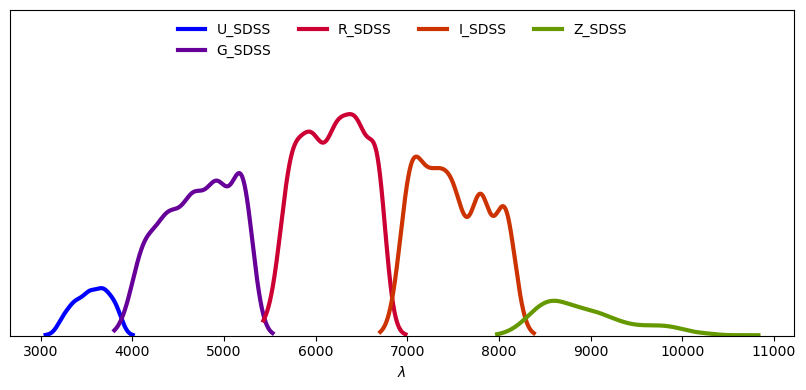

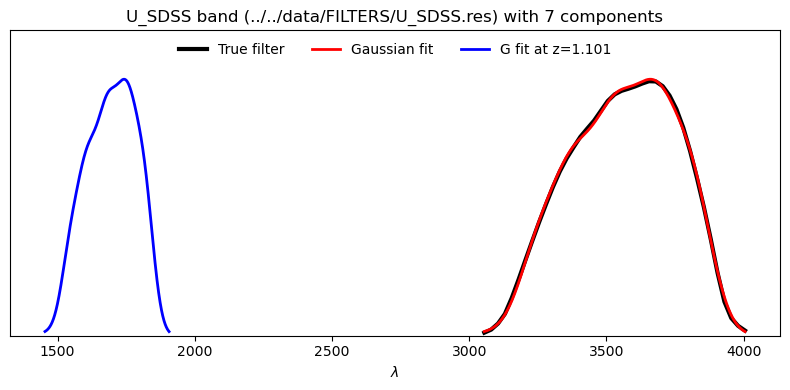

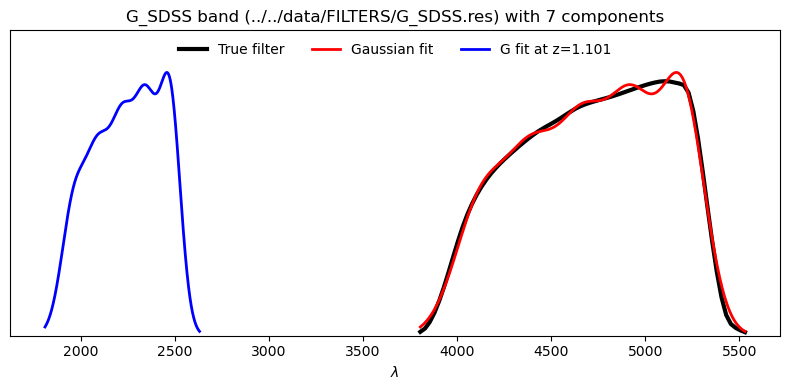

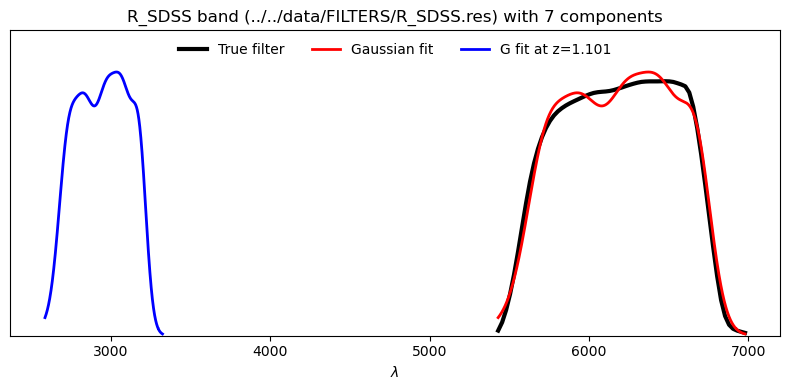

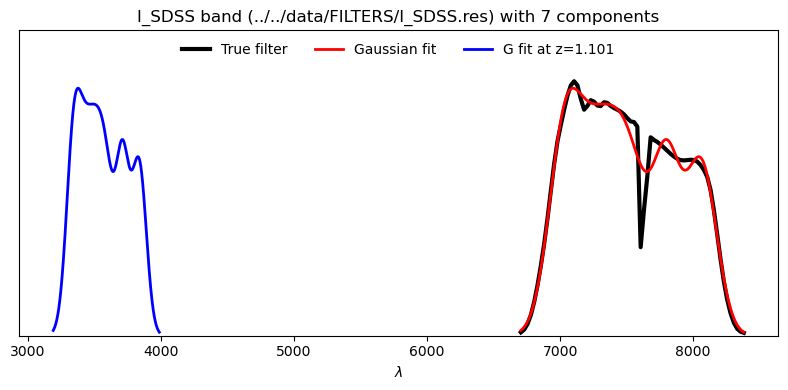

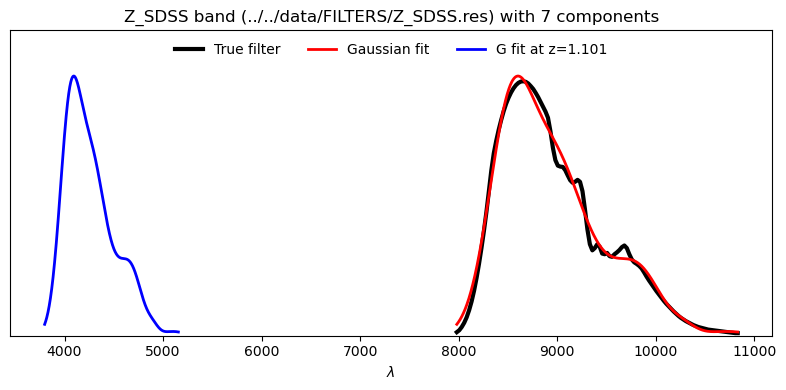

<Figure size 640x480 with 0 Axes>

In [12]:
%run ../../scripts/processFilters.py ./tests_nb/parametersTest.cfg

Second, we will process the library of SEDs and project them onto the filters,
(for the mean fct of the GP) with the following script (which may take a few minutes depending on the settings you set):

In [13]:
%run ../../scripts/processSEDs.py tests_nb/parametersTest.cfg

Third, we will make some mock data with those filters and SEDs:

In [14]:
%run ../../scripts/simulateWithSEDs-hdf5.py tests_nb/parametersTest.cfg

### Train and apply
Run the scripts below. There should be a little bit of feedback as it is going through the lines.
For up to 1e4 objects it should only take a few minutes max, depending on the settings above.

In [15]:
%run ../../scripts/templateFitting-hdf5.py tests_nb/parametersTest.cfg

--- TEMPLATE FITTING ---
Thread number / number of threads:  1 1
Input parameter file: tests_nb/parametersTest.cfg
Number of Target Objects 1000
Thread  0  analyzes lines  0  to  1000


/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/desc/Delight-hdf5io/Delight/scripts/templateFitting-hdf5.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))


localPDFs.shape =  (1000, 1001)
globalPDFs.shape =  (1000, 1001)
localMetrics.shape =  (1000, 11)
globalMetrics.shape =  (1000, 11)


In [16]:
%run ../../scripts/delight-learn-hdf5.py tests_nb/parametersTest.cfg

--- DELIGHT-LEARN ---
Number of Training Objects 1000
Thread  0  analyzes lines  0  to  1000


/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/desc/Delight-hdf5io/Delight/scripts/delight-learn-hdf5.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))


In [17]:
%run ../../scripts/delight-apply-hdf5.py tests_nb/parametersTest.cfg

--- DELIGHT-APPLY ---
Number of Training Objects 1000
Number of Target Objects 1000
Thread  0  analyzes lines  0  to  1000


/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/desc/Delight-hdf5io/Delight/scripts/delight-apply-hdf5.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/desc/Delight-hdf5io/Delight/scripts/delight-apply-hdf5.py:46: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))


0 0.13296794891357422 0.013680219650268555 0.013339757919311523
100 0.11671280860900879 0.011916875839233398 0.006083011627197266
200 0.10840392112731934 0.006965160369873047 0.008708953857421875
300 0.10074806213378906 0.007939815521240234 0.007476091384887695
400 0.10187125205993652 0.0064051151275634766 0.005850791931152344
500 0.0993499755859375 0.004820823669433594 0.004637956619262695
600 0.10307598114013672 0.007429838180541992 0.005574226379394531
700 0.10803079605102539 0.005103111267089844 0.006394863128662109
800 0.10391592979431152 0.006368875503540039 0.0058400630950927734
900 0.10052990913391113 0.005099058151245117 0.0060231685638427734


## Analyze the outputs

In [18]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile('tests_nb/parametersTest.cfg', verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

In [19]:
# Load the PDF files
metricscww = np.loadtxt(params['metricsFile'])
metrics = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

358 583 926 483 741 325 35 632 910 183 840 787 438 822 601 818 261 829 548 880 

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_34807/1794643373.py:21: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


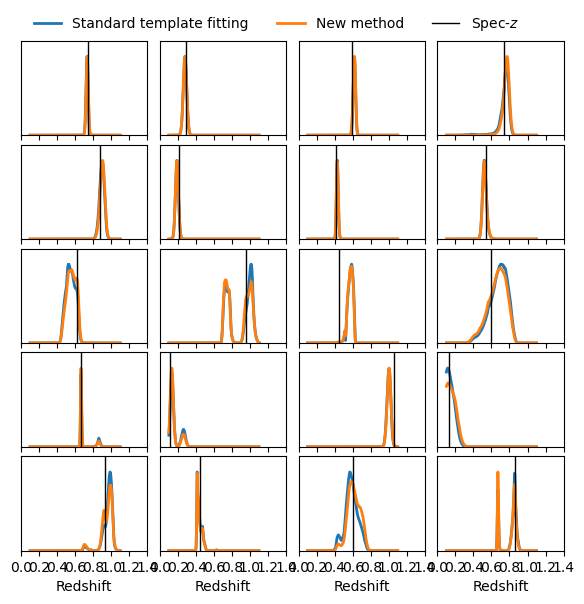

In [20]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(7, 6), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw, label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label=r'Spec-$z$')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 1.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


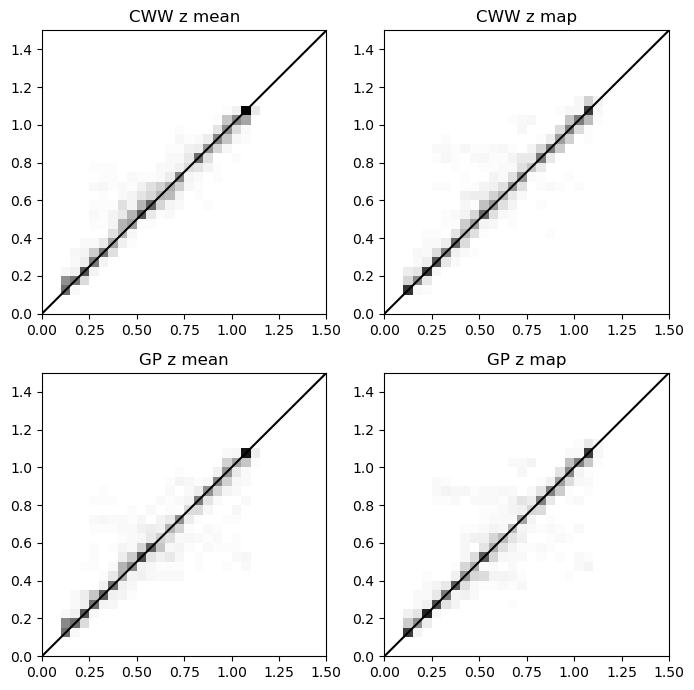

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
zmax = 1.5
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
fig.tight_layout()

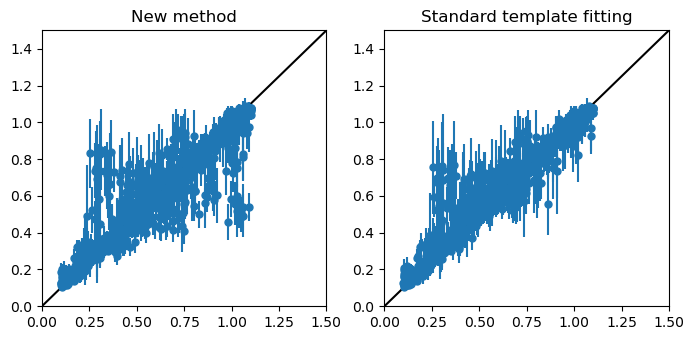

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

Text(0.5, 1.0, 'New method')

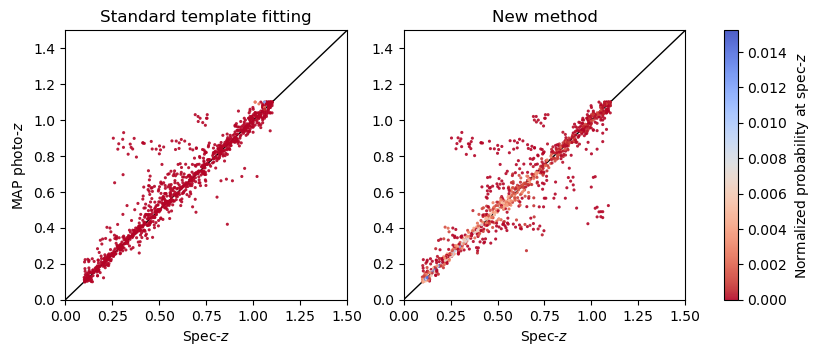

In [23]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.